In [1]:
# 사용 커널 TORCH_38
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
# 데이터 다운로드 및 전처리
NFLX = yf.download('NFLX', start='2012-01-01', end=datetime.now(), interval='1d')
NFLX.columns = NFLX.columns.droplevel(1)
NFLX = NFLX[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
NFLX.reset_index(inplace=True)
NFLX['Date'] = NFLX['Date'].dt.strftime('%Y-%m-%d 00:00:00-05:00')
NFLX.set_index('Date', inplace=True)

df = NFLX
data = df.filter(['Close'])
dataset = data.values
training_data_len = int(np.ceil(len(dataset) * .95))

[*********************100%***********************]  1 of 1 completed


In [4]:
# 데이터 스케일링
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training_data_len), :]

# x_train 및 y_train 생성
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# PyTorch 데이터셋 및 데이터로더 생성
class StockDataset(torch.utils.data.Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)

    def __len__(self):
        return len(self.y_data)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

train_dataset = StockDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

# LSTM 모델 정의
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        self.dense1 = nn.Linear(64, 25)
        self.dense2 = nn.Linear(25, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = self.dense1(out[:, -1, :])
        out = self.dense2(out)
        return out

In [5]:
# 모델 초기화 및 손실 함수/옵티마이저 설정
model = LSTM()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# 모델 학습
epochs = 1
for epoch in range(epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

# 테스트 데이터 준비
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# 예측
model.eval()
with torch.no_grad():
    x_test_tensor = torch.FloatTensor(x_test)
    predictions = model(x_test_tensor)
    predictions = scaler.inverse_transform(predictions.numpy())

# 데이터프레임 생성 및 예측 추가
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

C:\Users\kjy19\AppData\Local\Temp\ipykernel_20020\62696893.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


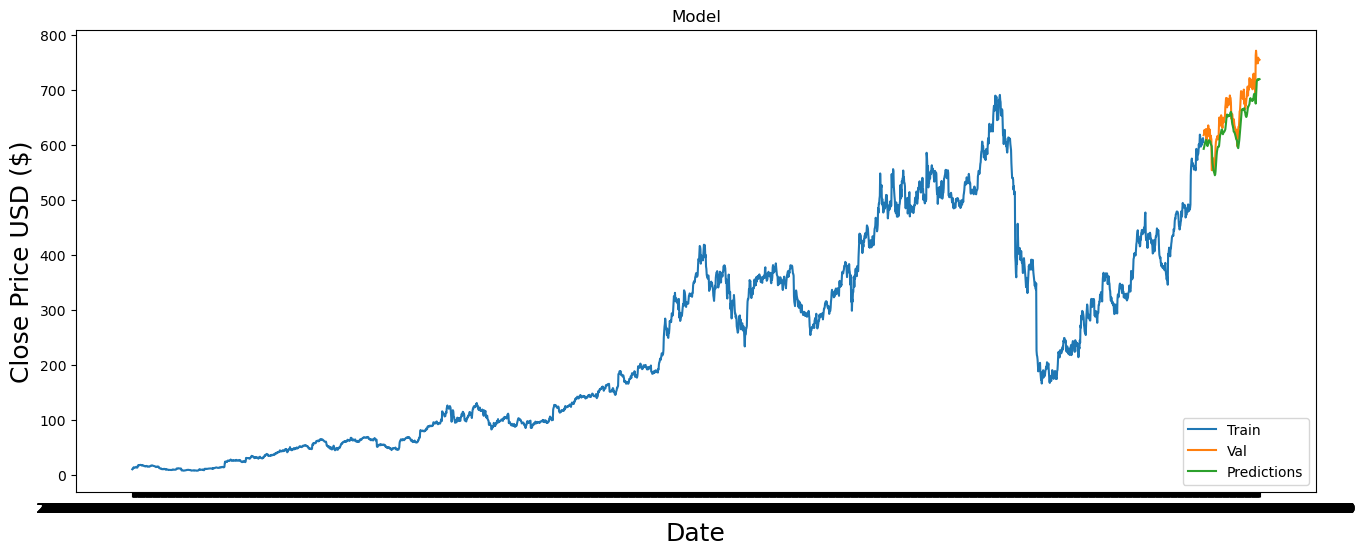

In [7]:
# 시각화
plt.figure(figsize=(16, 6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'], label='Train')
plt.plot(valid['Close'], label='Val')
plt.plot(valid['Predictions'], label='Predictions')
plt.legend(loc='lower right')
plt.show()

In [8]:
import joblib
def save_model_and_scaler(model, scaler, model_path='lstm_model.pth', scaler_path='scaler.pkl'):
    torch.save(model.state_dict(), model_path)
    joblib.dump(scaler, scaler_path)

save_model_and_scaler(model, scaler)

In [ ]:
def load_model_and_scaler(model_path='DY_lstm_model.pth', scaler_path='DY_scaler.pkl'):
    model = LSTM()
    model.load_state_dict(torch.load(model_path))
    model.eval()  # 모델을 평가 모드로 설정
    scaler = joblib.load(scaler_path)
    return model, scaler